## IMPORT LIBRARY

In [2]:
import numpy as np
import os
import platform
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

## CONSTRAINT

In [77]:
DEBUG = True

In [3]:
if platform.system() == 'Darwin':
    PATH = './'
else:
    PATH = '/content/drive/MyDrive/Colab Notebooks/Kaggle/House-Prices/'

## SET SEED

In [4]:
np.random.seed(1)

## READ DATA

In [5]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

# テストIDを別途保存しておく
test_ID = df_test['Id']


In [13]:
df_train.dtypes[df_train.dtypes != "object"].index

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## ANALYSYS

<AxesSubplot:xlabel='SalePrice', ylabel='PoolArea'>

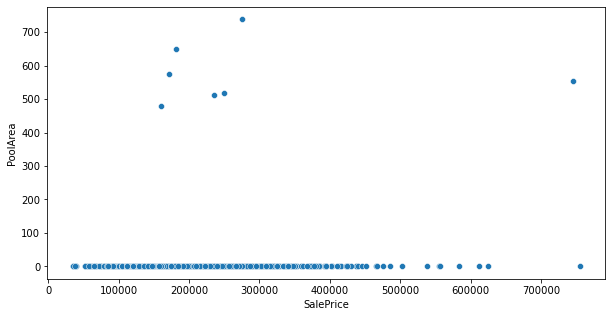

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))

numeric_features = df_train.dtypes[df_train.dtypes != "object"].index
sns.scatterplot(x=df_train['SalePrice'], y=df_train['PoolArea'])

## REMOVE OUTER VALUE

In [81]:
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

df_train["TotalSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"] + df_train["TotalBsmtSF"]
df_test["TotalSF"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"] + df_test["TotalBsmtSF"]

df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

## MAKE DATA

In [82]:

# データを合体
df = pd.concat([df_train, df_test], sort=False)

df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 'RL'が一番多いのでそれで埋める
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

df["Functional"] = df["Functional"].fillna("Typ")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

# 電気がないことはないので最頻値で埋める
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

df = df.drop(['Utilities'], axis=1)

# キッチンがないことはないので最頻値で埋める
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['MSSubClass'] = df['MSSubClass'].fillna("None")

## カテゴリにしたい数値型の特徴量を文字列に変換
#MSSubClass=The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))
    
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# 正規化    
numeric_features = df.dtypes[df.dtypes != "object"].index
# 歪みを数値化
skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewness = skewed_features[abs(skewed_features) > 0.75]
skewed_features = high_skewness.index

# 0.9以上のものを補正をかける
for feature in skewed_features:
    if feature != 'SalePrice': 
        df[feature] = boxcox1p(df[feature], 0.15)

# one-hot-Encoding
df = pd.get_dummies(df)

# 訓練データを作成
y = np.log1p(df[:df_train.shape[0]]['SalePrice'])
X = df[:df_train.shape[0]].drop(['SalePrice'], axis=1)

# 検証
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [83]:
X.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,0.730463,1,3,0.0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,5,6.221214,19.712205,0.730463,1,3,0.0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,10,5.914940,20.347241,0.730463,1,0,0.0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,11,5.684507,19.691553,0.730463,1,0,0.0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,10,6.314735,21.325160,0.730463,1,0,0.0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


## RSME

In [84]:
def rmse(y_true,y_pred):
    #RMSEを算出
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

## MAKE MODEL AND FIT (XGBOOST)

In [85]:
import copy
import optuna
from sklearn.model_selection import cross_validate

trains = xgb.DMatrix(X_train, label=y_train)
tests = xgb.DMatrix(X_test, label=y_test)

base_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

tmp_params = copy.deepcopy(base_params)

watchlist = [(X_train, 'train'), (X_test, 'eval')]

def optimizer(trial):
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr = xgb.XGBRegressor(eta = eta, gamma = gamma, max_depth = max_depth,
                           min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                           subsample = subsample,reg_lambda = reg_lambda,reg_alpha = reg_alpha)
    score_funcs = {
        'rmse': make_scorer(rmse),  # make_scorer() でラップする
    }
    scores = cross_validate(regr, X_train, y_train, cv=5, scoring=score_funcs)
    print(scores)
    mean_rmse = scores['test_rmse'].mean()
    return mean_rmse

#study = optuna.create_study(direction='minimize')
#study.optimize(optimizer, n_trials=500)

In [86]:
#study.best_params

In [87]:
xgboost = make_pipeline(RobustScaler(), xgb.XGBRegressor(eta=0.6752981403332644, 
                            gamma=0.00019806565556055886, 
                            max_depth=2, 
                            min_child_weight=0.0001309781675638748, 
                            max_delta_step=0.3034212265985207,
                            subsample=0.5268559375798426,
                            reg_lambda=43.32176448126586,
                            reg_alpha=0.33670821989661315))
xgboost.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, eta=0.6752981403332644,
                              gamma=0.00019806565556055886, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.675298154,
                              max_delta_step=0.3034212265985207, max_depth=2,
                              min_child_weight=0.0001309781675638748,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              random_state=0, reg_alpha=0.33670821989661315,
                              reg_lambda=43.32176448126586, scale_pos_weight=1,
              

## MAKE MODEL AND FIT (LIGHT BGM)

In [88]:
import optuna.integration.lightgbm as lgbo
opt_params = { "objective":"regression", "metric":"rmse"}
reg_train = lgbm.Dataset(X_train, y_train)
reg_eval = lgbm.Dataset(X_test, y_test, reference=reg_train)

#opt=lgbo.train(opt_params, reg_train, valid_sets = reg_eval, verbose_eval=False, num_boost_round = 5)

In [89]:
#opt.params

In [90]:
"""
{'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 85,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.5374366835020357,
 'bagging_freq': 3,
 'min_child_samples': 5}
"""
lightbgm = make_pipeline(RobustScaler(), lgbm.LGBMRegressor(objective='regression', 
                             num_leaves=85, 
                             feature_fraction=0.6, 
                             bagging_fraction=0.5374366835020357, 
                             bagging_freq=3, 
                             min_child_samples=5, 
                             max_depth=2,
                             feature_pre_filter=False))
lightbgm.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.5374366835020357,
                               bagging_freq=3, feature_fraction=0.6,
                               feature_pre_filter=False, max_depth=2,
                               min_child_samples=5, num_leaves=85,
                               objective='regression'))])

## BEST PARAMS(LIGHTBGM)

In [91]:
#gd.best_params_

## Gradient Boosting regressor

In [92]:
from sklearn.ensemble import GradientBoostingRegressor 
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=2, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, loss='huber', random_state =1)  
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=2,
                          max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=5, n_estimators=3000,
                          random_state=1)

## Lasso

In [93]:
from sklearn.linear_model import Lasso
lasso = make_pipeline(RobustScaler(), Lasso(0.0001))
lasso.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0001))])

## Ridge

In [94]:
from sklearn.linear_model import Ridge
ridge = make_pipeline(RobustScaler(), Ridge(0.1))
ridge.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()), ('ridge', Ridge(alpha=0.1))])

## Random Forest Regressor

In [95]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['mse', 'mae'])
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 1000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,1000)
    n_estimators =  trial.suggest_int('n_estimators', 1, 1000)
    min_samples_split = trial.suggest_int('min_samples_split',2,5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)

    regr = RandomForestRegressor(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
                                 min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,
                                 n_jobs=2)

    score_funcs = {
        'rmse': make_scorer(rmse),  # make_scorer() でラップする
    }
    scores = cross_validate(regr, X_train, y_train, cv=5, scoring=score_funcs)
    print(scores)
    mean_rmse = scores['test_rmse'].mean()
    return mean_rmse

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

In [96]:
#study.best_params

In [97]:
#randf = RandomForestRegressor(max_depth=5, n_estimators=5000)
#randf.fit(X_train, y_train)

## STACKING

In [98]:

xgboost_pred1 = xgboost.predict(X_train)
lightbgm_pred1= lightbgm.predict(X_train)
gra_pred1= gbr.predict(X_train)
lasso_pred1= lasso.predict(X_train)
ridge_pred1= ridge.predict(X_train)
#randf_pred1= randf.predict(X_train)


print('[TRAIN]')
print ("xgboost rsme: {:.6f}".format(rmse(y_train, xgboost_pred1)))
print ("lightbgm rsme: {:.6f}".format(rmse(y_train, lightbgm_pred1)))
print ("gra rsme: {:.6f}".format(rmse(y_train, gra_pred1)))
print ("lasso rsme: {:.6f}".format(rmse(y_train, lasso_pred1)))
print ("ridge rsme: {:.6f}".format(rmse(y_train, ridge_pred1)))
#print ("randf rsme: {:.6f}".format(rmse(y_train, randf_pred1)))

# 結果の検証 
xgboost_pred = xgboost.predict(X_test)
lightbgm_pred= lightbgm.predict(X_test)
gra_pred= gbr.predict(X_test)
lasso_pred= lasso.predict(X_test)
ridge_pred= ridge.predict(X_test)
#randf_pred= randf.predict(X_test)

print('[VALID]')
print ("xgboost rsme: {:.6f}".format(rmse(y_test, xgboost_pred)))
print ("lightbgm rsme: {:.6f}".format(rmse(y_test, lightbgm_pred)))
print ("gra rsme: {:.6f}".format(rmse(y_test, gra_pred)))
print ("lasso rsme: {:.6f}".format(rmse(y_test, lasso_pred)))
print ("ridge rsme: {:.6f}".format(rmse(y_test, ridge_pred)))
#print ("randf rsme: {:.6f}".format(rmse(y_test, randf_pred)))


#final_estimator = MLPRegressor(solver="sgd", random_state=1)
final_estimator = LinearRegression()
estimators = [
    ('xgboost', xgboost),
    ('lightbgm', lightbgm), 
    ('gra', gbr), 
    ('lasso', lasso)
    #('ridge', ridge)
]
st_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator, cv=10)

st_model.fit(X_train, y_train)

y_pred_1 = st_model.predict(X_train)
y_pred = st_model.predict(X_test)
print("\n")
print("TRAIN: Stacking Model rsme: {:.6f}".format(rmse(y_train, y_pred_1)))
print("TEST: Stacking Model rsme: {:.6f}".format(rmse(y_test, y_pred)))

[TRAIN]
xgboost rsme: 0.104643
lightbgm rsme: 0.097722
gra rsme: 0.060709
lasso rsme: 0.089902
ridge rsme: 0.087993
[VALID]
xgboost rsme: 0.135786
lightbgm rsme: 0.123935
gra rsme: 0.117313
lasso rsme: 0.121865
ridge rsme: 0.133382


TRAIN: Stacking Model rsme: 0.072323
TEST: Stacking Model rsme: 0.114997


## PREDICT AND SUBMIT

In [99]:
test = df[df_train.shape[0]:].drop(['SalePrice'], axis=1)

submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": np.expm1(st_model.predict(test))
})
submission.to_csv(f'{PATH}submission.csv', index=False)

In [100]:
submission.head()

,Id,SalePrice
0,1461,119072.246533
1,1462,163041.016263
2,1463,188418.739996
3,1464,195523.508950
4,1465,193631.279042
